## Random Froest Classifier

In [38]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Load the CSV file
df = pd.read_csv("cleaned_legal_metadata.csv")

# Extract case type from docket number
def extract_case_type(docket):
    docket = str(docket).upper()
    if 'CR' in docket:
        return 'Criminal'
    elif 'CV' in docket or 'CIVIL' in docket:
        return 'Civil'
    elif 'MDL' in docket:
        return 'MDL'
    else:
        return 'Other'

df['case_type'] = df['docket_number'].apply(extract_case_type)

# Focus on major classes only
df = df[df['case_type'].isin(['Civil', 'Criminal', 'Other'])]

# Prepare features and labels
X_text = df['name'].astype(str)
y = df['case_type']

# Vectorize case name text
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(X_text)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = rf_model.predict(X_test)
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred))


Random Forest Classification Report:
              precision    recall  f1-score   support

       Civil       0.75      1.00      0.86        12
    Criminal       1.00      0.25      0.40         4
       Other       1.00      0.50      0.67         2

    accuracy                           0.78        18
   macro avg       0.92      0.58      0.64        18
weighted avg       0.83      0.78      0.73        18



## LSTM (Long Short-Term Memory)

In [39]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

# Step 1: Load data
df = pd.read_csv("cleaned_legal_metadata.csv")

# Step 2: Derive target variable from 'docket_number'
def extract_case_type(docket):
    docket = str(docket).upper()
    if 'CR' in docket:
        return 'Criminal'
    elif 'CV' in docket or 'CIVIL' in docket:
        return 'Civil'
    elif 'MDL' in docket:
        return 'MDL'
    else:
        return 'Other'

df['case_type'] = df['docket_number'].apply(extract_case_type)
df = df[df['case_type'].isin(['Civil', 'Criminal', 'Other'])]  # keep consistent classes

# Step 3: Prepare text and labels
X_text = df['name'].astype(str)
y = df['case_type']

# Step 4: Tokenize text
max_words = 5000
max_len = 50

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_text)
X_seq = tokenizer.texts_to_sequences(X_text)
X_pad = pad_sequences(X_seq, maxlen=max_len)

# Step 5: Encode labels
encoder = LabelEncoder()
y_enc = encoder.fit_transform(y)
y_cat = to_categorical(y_enc)  # for softmax output

# Step 6: Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_pad, y_cat, test_size=0.2, random_state=42)

# Step 7: Build LSTM model
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=64, input_length=max_len))
model.add(LSTM(64))
model.add(Dense(3, activation='softmax'))  # 3 classes: Civil, Criminal, Other

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Step 8: Train model
print("Training LSTM...")
model.fit(X_train, y_train, epochs=5, batch_size=16, verbose=1)

# Step 9: Evaluate
y_pred = model.predict(X_test).argmax(axis=1)
y_true = y_test.argmax(axis=1)

print("\nLSTM Classification Report:")
print(classification_report(encoder.inverse_transform(y_true), encoder.inverse_transform(y_pred)))


Training LSTM...
Epoch 1/5


c:\Users\manas\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5008 - loss: 1.0888
Epoch 2/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7012 - loss: 1.0214
Epoch 3/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6552 - loss: 0.8875
Epoch 4/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6900 - loss: 0.7952
Epoch 5/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6743 - loss: 0.7293
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step

LSTM Classification Report:
              precision    recall  f1-score   support

       Civil       0.67      1.00      0.80        12
    Criminal       0.00      0.00      0.00         4
       Other       0.00      0.00      0.00         2

    accuracy                           0.67        18
   macro avg       0.22      0.33      0.27        18
weighted avg       0.44      0.67      0.53        18



c:\Users\manas\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\manas\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\manas\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

## RNN

In [41]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense

# Step 1: Load your dataset
df = pd.read_csv("cleaned_legal_metadata.csv")

# Step 2: Extract case types
def extract_case_type(docket):
    docket = str(docket).upper()
    if 'CR' in docket:
        return 'Criminal'
    elif 'CV' in docket or 'CIVIL' in docket:
        return 'Civil'
    elif 'MDL' in docket:
        return 'MDL'
    else:
        return 'Other'

df['case_type'] = df['docket_number'].apply(extract_case_type)
df = df[df['case_type'].isin(['Civil', 'Criminal', 'Other'])]

# Step 3: Prepare features and labels
X_text = df['name'].astype(str)
y = df['case_type']

# Step 4: Tokenize and pad sequences
max_words = 5000
max_len = 50

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_text)
X_seq = tokenizer.texts_to_sequences(X_text)
X_pad = pad_sequences(X_seq, maxlen=max_len)

# Step 5: Encode labels
encoder = LabelEncoder()
y_enc = encoder.fit_transform(y)
y_cat = to_categorical(y_enc)

# Step 6: Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_pad, y_cat, test_size=0.2, random_state=42)

# Step 7: Build RNN model
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=64, input_length=max_len))
model.add(SimpleRNN(64))  # <-- SimpleRNN layer
model.add(Dense(3, activation='softmax'))  # 3 output classes

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Step 8: Train the model
print("Training Simple RNN...")
model.fit(X_train, y_train, epochs=5, batch_size=16, verbose=1)

# Step 9: Evaluate performance
y_pred = model.predict(X_test).argmax(axis=1)
y_true = y_test.argmax(axis=1)

print("\nSimple RNN Classification Report:")
print(classification_report(encoder.inverse_transform(y_true), encoder.inverse_transform(y_pred)))


Training Simple RNN...
Epoch 1/5


c:\Users\manas\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4852 - loss: 1.0600
Epoch 2/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6717 - loss: 0.7909
Epoch 3/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7602 - loss: 0.5986 
Epoch 4/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9020 - loss: 0.4360 
Epoch 5/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8668 - loss: 0.3402 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step

Simple RNN Classification Report:
              precision    recall  f1-score   support

       Civil       0.65      0.92      0.76        12
    Criminal       0.00      0.00      0.00         4
       Other       0.00      0.00      0.00         2

    accuracy                           0.61        18
   macro avg       0.22      0.31      0.25        18
weighted avg       0.43      0.61      0.51        18



c:\Users\manas\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\manas\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\manas\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

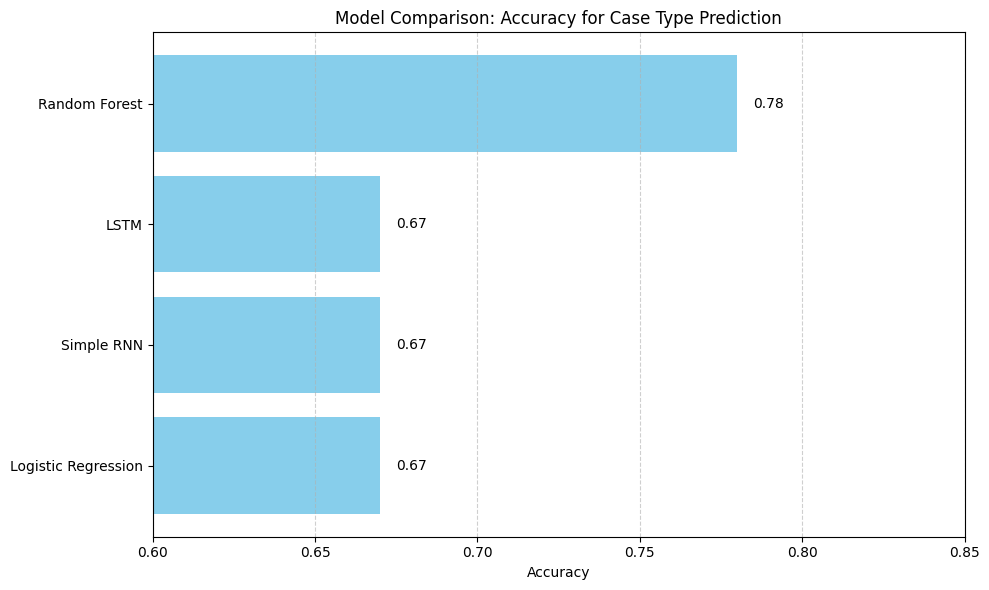

In [45]:
import pandas as pd
import matplotlib.pyplot as plt

# Replace these with actual scores if available
results = {
    "Logistic Regression": 0.67,
    "Random Forest": 0.78,
    "Simple RNN": 0.67,
    "LSTM": 0.67
}

# Convert to DataFrame for plotting
df_results = pd.DataFrame(list(results.items()), columns=["Model", "Accuracy"])
df_results.sort_values("Accuracy", ascending=True, inplace=True)

# Plotting
plt.figure(figsize=(10, 6))
bars = plt.barh(df_results["Model"], df_results["Accuracy"], color='skyblue')
plt.xlabel("Accuracy")
plt.title("Model Comparison: Accuracy for Case Type Prediction")
plt.xlim(0.6, 0.85)

# Add accuracy values on bars
for bar in bars:
    plt.text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2,
             f"{bar.get_width():.2f}", va='center')

plt.tight_layout()
plt.grid(axis='x', linestyle='--', alpha=0.6)

plt.show()


# Fine Tuning

## Random Forst Classifier

In [48]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from scipy.stats import randint

# Load the CSV file
df = pd.read_csv("cleaned_legal_metadata.csv")

# Extract case type from docket number
def extract_case_type(docket):
    docket = str(docket).upper()
    if 'CR' in docket:
        return 'Criminal'
    elif 'CV' in docket or 'CIVIL' in docket:
        return 'Civil'
    elif 'MDL' in docket:
        return 'MDL'
    else:
        return 'Other'

df['case_type'] = df['docket_number'].apply(extract_case_type)

# Filter relevant classes
df = df[df['case_type'].isin(['Civil', 'Criminal', 'Other'])]

# Prepare features and labels
X_text = df['name'].astype(str)
y = df['case_type']

# Vectorize text
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(X_text)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Hyperparameter grid
param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': [10, 20, 50, None],
    'max_features': ['sqrt', 'log2', None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Randomized search with cross-validation
rf = RandomForestClassifier(random_state=42)
rand_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=20,
    cv=5,
    scoring='f1_macro',
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Fit model
rand_search.fit(X_train, y_train)

# Evaluate best model
y_pred = rand_search.predict(X_test)
print("Best Parameters:", rand_search.best_params_)
print("\nFine-Tuned Random Forest Classification Report:")
print(classification_report(y_test, y_pred))


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters: {'max_depth': 50, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 149}

Fine-Tuned Random Forest Classification Report:
              precision    recall  f1-score   support

       Civil       0.79      0.92      0.85        12
    Criminal       1.00      0.25      0.40         4
       Other       0.33      0.50      0.40         2

    accuracy                           0.72        18
   macro avg       0.71      0.56      0.55        18
weighted avg       0.78      0.72      0.70        18



## LSTM

In [51]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Load data
df = pd.read_csv("cleaned_legal_metadata.csv")

# Extract target variable
def extract_case_type(docket):
    docket = str(docket).upper()
    if 'CR' in docket:
        return 'Criminal'
    elif 'CV' in docket or 'CIVIL' in docket:
        return 'Civil'
    elif 'MDL' in docket:
        return 'MDL'
    else:
        return 'Other'

df['case_type'] = df['docket_number'].apply(extract_case_type)
df = df[df['case_type'].isin(['Civil', 'Criminal', 'Other'])]

# Prepare text and labels
X_text = df['name'].astype(str)
y = df['case_type']

# Tokenize
max_words = 6000
max_len = 60

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_text)
X_seq = tokenizer.texts_to_sequences(X_text)
X_pad = pad_sequences(X_seq, maxlen=max_len)

# Encode labels
encoder = LabelEncoder()
y_enc = encoder.fit_transform(y)
y_cat = to_categorical(y_enc)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_pad, y_cat, test_size=0.2, random_state=42)

# Build model
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_len))
model.add(LSTM(128, dropout=0.3, recurrent_dropout=0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train with early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

print("Training fine-tuned LSTM...")
model.fit(
    X_train, y_train,
    epochs=15,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)

# Evaluate
y_pred = model.predict(X_test).argmax(axis=1)
y_true = y_test.argmax(axis=1)

print("\nFine-Tuned LSTM Classification Report:")
print(classification_report(encoder.inverse_transform(y_true), encoder.inverse_transform(y_pred)))


c:\Users\manas\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Training fine-tuned LSTM...
Epoch 1/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 535ms/step - accuracy: 0.5164 - loss: 1.0920 - val_accuracy: 0.5714 - val_loss: 1.0774
Epoch 2/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.7259 - loss: 1.0643 - val_accuracy: 0.5714 - val_loss: 1.0476
Epoch 3/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.6529 - loss: 1.0270 - val_accuracy: 0.5714 - val_loss: 0.9982
Epoch 4/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.6946 - loss: 0.9526 - val_accuracy: 0.5714 - val_loss: 0.9351
Epoch 5/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.7154 - loss: 0.8761 - val_accuracy: 0.5714 - val_loss: 0.9824
Epoch 6/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.7050 - loss: 0.7901 - val_accuracy: 0.5714 - val_loss: 0.9898
Epoch 7/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.6842 - loss: 0.8055 - val_accuracy: 0.5714 - val_loss: 0.9469
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step

Fine-Tuned LSTM Classification Report:
              pre

c:\Users\manas\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\manas\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\manas\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

## RNN

In [52]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Build improved SimpleRNN model
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_len))  # Larger embedding
model.add(SimpleRNN(128))  # More RNN units
model.add(Dropout(0.5))    # Dropout for regularization
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

print("Training fine-tuned SimpleRNN model...")
model.fit(
    X_train, y_train,
    epochs=20,               # More epochs for better learning
    batch_size=32,           # Larger batch size
    validation_split=0.1,    # Use validation data
    callbacks=[early_stop],  # Early stopping
    verbose=1
)

# Evaluate
y_pred = model.predict(X_test).argmax(axis=1)
y_true = y_test.argmax(axis=1)

print("\nFine-tuned SimpleRNN Classification Report:")
print(classification_report(encoder.inverse_transform(y_true), encoder.inverse_transform(y_pred)))


Training fine-tuned SimpleRNN model...
Epoch 1/20


c:\Users\manas\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 338ms/step - accuracy: 0.3375 - loss: 1.0754 - val_accuracy: 0.5714 - val_loss: 0.9920
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.7366 - loss: 0.8261 - val_accuracy: 0.5714 - val_loss: 0.9076
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.7679 - loss: 0.6732 - val_accuracy: 0.5714 - val_loss: 1.0008
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.7054 - loss: 0.7706 - val_accuracy: 0.5714 - val_loss: 0.9554
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.7163 - loss: 0.7141 - val_accuracy: 1.0000 - val_loss: 0.8249
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9261 - loss: 0.4921 - val_accuracy: 0.7143 - val_loss: 0.6933
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.8317 - loss: 0.5014 - val_accuracy: 0.8571 - val_loss: 0.6587
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.8948 - loss: 0.4071 - val_accuracy: 0.5714 - val_loss: 0.6922
Epoch 9/20

c:\Users\manas\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\manas\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\manas\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

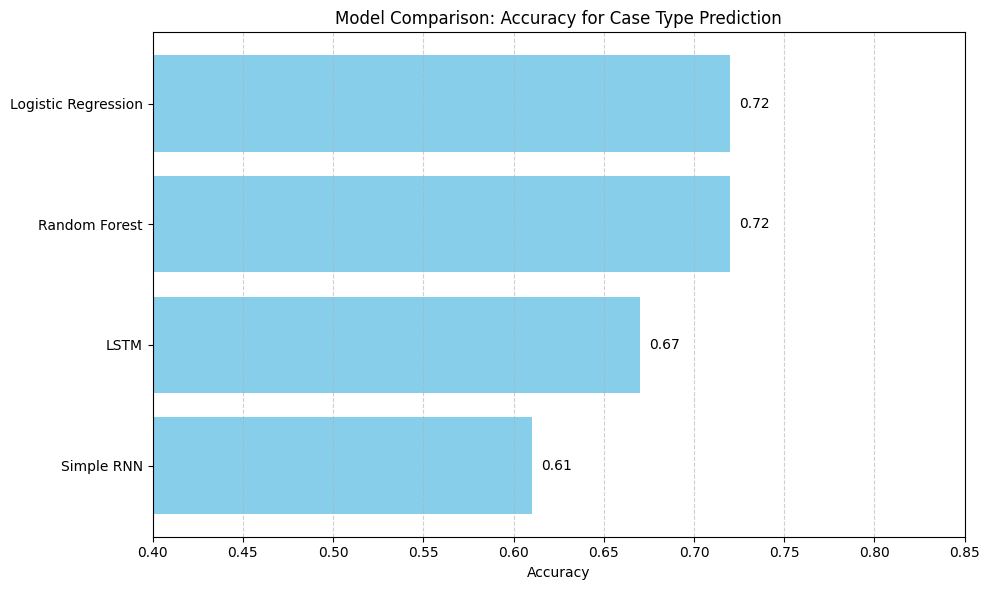

In [54]:
import pandas as pd
import matplotlib.pyplot as plt

# Replace these with actual scores if available
results = {
    "Logistic Regression": 0.72,
    "Random Forest": 0.72,
    "Simple RNN": 0.61,
    "LSTM": 0.67
}

# Convert to DataFrame for plotting
df_results = pd.DataFrame(list(results.items()), columns=["Model", "Accuracy"])
df_results.sort_values("Accuracy", ascending=True, inplace=True)

# Plotting
plt.figure(figsize=(10, 6))
bars = plt.barh(df_results["Model"], df_results["Accuracy"], color='skyblue')
plt.xlabel("Accuracy")
plt.title("Model Comparison: Accuracy for Case Type Prediction")
plt.xlim(0.4, 0.85)

# Add accuracy values on bars
for bar in bars:
    plt.text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2,
             f"{bar.get_width():.2f}", va='center')

plt.tight_layout()
plt.grid(axis='x', linestyle='--', alpha=0.6)

plt.show()
